<a href="https://colab.research.google.com/github/akaver/NLP2019/blob/master/Lab08b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using and training word embeddings for simple named entity recognition

In this lab, we will train a simple feed-forward Pytorch neural network to to nmed entity recognition. We will use the same dataset as a few weeks ago.



Now, let's import some packages that we will later need.

In [0]:
import sklearn
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader


Let's also download and read the NER train and dev data. We use the same functions as a few weeks ago.

In [0]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

--2019-03-19 11:06:29--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3281528 (3.1M) [text/plain]
Saving to: ‘eng.train’

eng.train           100%[===================>]   3.13M  --.-KB/s    in 0.1s    

2019-03-19 11:06:32 (30.5 MB/s) - ‘eng.train’ saved [3281528/3281528]



In [0]:
!wget -q https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa

In [0]:
from itertools import chain, groupby
def read_conll(filename):  
    result = []
    f = open(filename)
    lines = (str.strip(line) for line in  f)
    groups = (grp for nonempty, grp in groupby(lines, bool) if nonempty)

    for group in groups:
        group = list(group)

        obs, lbl = zip(*(ln.rsplit(None, 1) for ln in group))
        lbl = [l.lstrip("B-").lstrip("I-") for l in lbl]
        word = [x.split()[0] for x in obs]

        result.append(list(zip(word, lbl)))
    return result

In [0]:
train_data = read_conll("eng.train")
dev_data = read_conll("eng.testa")

Now, we will construct the vocabulary of words that the model knows about. We use all words that occur in training data at least twice. All other words are mapped to special word `<unk>`.

Each word is associated with an integer (the ID of the word).

Also, each output label is associated with an integer.

In [0]:
from collections import Counter
word_counter = Counter()
for sentence in train_data:
  for word, label in sentence:
    word_counter[word] += 1

In [0]:
vocabulary = {}
vocabulary["<unk>"] = 0
vocabulary["<s>"] = 1
vocabulary["</s>"] = 2
for word in word_counter:
  if word_counter[word] > 1:
    vocabulary[word] = len(vocabulary)
    
label_vocabulary = {}
label_vocabulary["O"] = 0
label_vocabulary["ORG"] = 1
label_vocabulary["LOC"] = 2
label_vocabulary["MISC"] = 3
label_vocabulary["PER"] = 4

Now, we will convert our training data to a form needed by Pytorch. For this, we have to inherit Pytorch Dataset class and implement a few methods.

In [0]:

class NERDataset(Dataset):
    """Name Classification dataset"""

    def __init__(self, data ):
        items = []
        labels = []
        for sentence in data:
          for i in range(len(sentence)):
            if i > 0:
              prevw = vocabulary.get(sentence[i-1][0], 0)
            else:
              prevw = vocabulary["<s>"]
            if i+1 < len(sentence):
              nextw = vocabulary.get(sentence[i+1][0], 0)
            else:
              nextw = vocabulary["</s>"]
            items.append((prevw, vocabulary.get(sentence[i][0], 0), nextw))
            labels.append(label_vocabulary[sentence[i][1]])
        self.X = torch.from_numpy(np.array(items).astype(int)).long()
        self.y = torch.from_numpy(np.array(labels).astype(int)).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        sample = {'X': X, 'y': y}
        return sample

In [0]:
train_dataset = NERDataset(train_data)

The `train_dataset` variable now holds actual training examples that we'll feed to the neural net during training.

In [0]:
train_dataset[10]

{'X': tensor([ 1, 12, 13]), 'y': tensor(4)}

Now, we will define our model. It inherits from Pytorch nn.Module. 

The model first projects the three words in our data (prev, current, next) to vector space, using the special `Embedding` class. Embeddings are concatenated, and passed through an affine (linear) layer, with a ReLU non-linearity. The output goes to softmax.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class NERNN(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size):
        super(NERNN, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(embedding_dim * 3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x = self.embeddings(x).view(-1, (embedding_dim * 3))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

Next, we will implement our training loop. It loops through minibatches. For each minibatch, it computes the outputs of the model with regard of the inputs, calculates the loss w.r.t to the real targets, computes gradients via backpropagation, and updates the model.

In [0]:
def train(model, dataloader, num_epochs):
    cuda = torch.cuda.is_available()
    
    if cuda:
        model.cuda()
    optimizer = torch.optim.Adam(model.parameters())
    loss_function = nn.NLLLoss()
    loss_history = []
    for i in range(num_epochs):
        for batch in dataloader:
            model.zero_grad()
            X = batch['X']
            
            y = batch['y']
            if cuda:
                X = X.cuda()
                y = y.cuda()
            outputs = model(X)
            loss = loss_function(outputs, y)
            loss.backward()
            optimizer.step()
            
        loss_history.append(loss.item())
        print('epoch[%d] log loss: %.4f' % (i, loss.item()))
    return loss_history

Now, we can create our model, with some (randomly selected) hyperparameters.

In [0]:
vocab_size = len(vocabulary)
embedding_dim = 50 # dimensionality of word embeddings
hidden_dim = 100   # dim of hidden layer
output_size = len(label_vocabulary) # number of classes


model = NERNN(vocab_size, embedding_dim, hidden_dim, output_size)

When training, we have to wrap our data using DataLoader, which shuffles our data and splits it into minibatches.

In [0]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
loss_history = train(model, train_dataloader, 5)

epoch[0] log loss: 0.1536
epoch[1] log loss: 0.1693
epoch[2] log loss: 0.1035
epoch[3] log loss: 0.0043
epoch[4] log loss: 0.0047


Alright, the model is trained!

Let's plot our training loss values thoughout the training.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

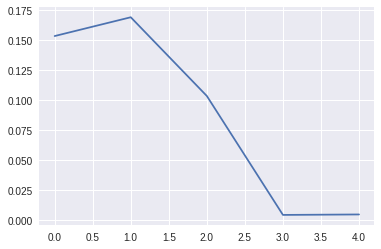

In [0]:
plt.plot(loss_history)

The following part applies the model to dev data and calculates the accuracy.

In [0]:
dev_dataset = NERDataset(dev_data)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

In [0]:
def predict(model, dataloader):
    cuda = torch.cuda.is_available()
    ground_truth = []
    predictions = []
    for batch in dataloader:
        X = batch['X']
        y = batch['y']
        if cuda:
            X = X.cuda()
            y = y.cuda()
        outputs = model(X)
        _, y_preds = torch.max(outputs, dim=1)
        ground_truth.append(y.data.cpu().numpy())
        predictions.append(y_preds.data.cpu().squeeze().numpy())
    return np.concatenate(ground_truth), np.concatenate(predictions)

In [0]:
ground_truth, predictions = predict(model, dev_dataloader)

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [0]:
print(accuracy_score(ground_truth, predictions))

0.9557951064407305


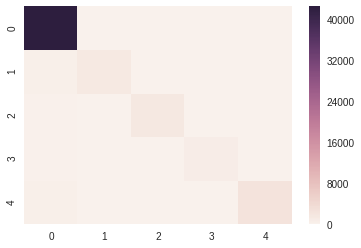

In [0]:
sns.heatmap(confusion_matrix(ground_truth, predictions))

# Using pretrained embeddings
Next, we try to use pretrained word embeddings, instead of training them from scratch.

We will use the gensim package for reading the pretrained Engish embeddings.

In [0]:
!pip install gensim
from gensim.models import KeyedVectors

In [0]:
!wget --no-check-certificate https://phon.ioc.ee/~tanela/tmp/glove.6B.50d.w2vformat.txt.gz
!gunzip glove.6B.50d.w2vformat.txt.gz
wv_en =  KeyedVectors.load_word2vec_format("glove.6B.50d.w2vformat.txt", binary=False)

--2019-03-19 11:11:43--  https://phon.ioc.ee/~tanela/tmp/glove.6B.50d.w2vformat.txt.gz
Resolving phon.ioc.ee (phon.ioc.ee)... 193.40.251.126
Connecting to phon.ioc.ee (phon.ioc.ee)|193.40.251.126|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 69182535 (66M) [application/x-gzip]
Saving to: ‘glove.6B.50d.w2vformat.txt.gz’

glove.6B.50d.w2vfor 100%[===================>]  65.98M  7.50MB/s    in 29s     

2019-03-19 11:12:14 (2.27 MB/s) - ‘glove.6B.50d.w2vformat.txt.gz’ saved [69182535/69182535]



The wv_en variable is now a gensim object that holds pretrained embeddings:

In [0]:
wv_en.most_similar("horse")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('horses', 0.8595937490463257),
 ('dog', 0.7907582521438599),
 ('riding', 0.7717962861061096),
 ('bull', 0.7642240524291992),
 ('breeders', 0.7027289867401123),
 ('cat', 0.7017536759376526),
 ('derby', 0.6957983374595642),
 ('ride', 0.6939681172370911),
 ('camel', 0.6921409964561462),
 ('bike', 0.6891596913337708)]

We will now have to pre-fill the embeddings matrix with the pre-trained  embeddings. For this we have to map the word IDs to correct positions.

Special care has to be taken for unknown words (words in our data but not in the pretrained vocabulary) and the special tokens that we use in our model. 

We let the embeddings of unknown words to be all-zero, and the embeddings of `<s>` and `</s>` we'll fill with -1 and 1, respectively. This is a rather heuristic decision.

In [0]:
pretrained_embeddings = torch.FloatTensor(len(vocabulary), wv_en.vector_size)
for word in vocabulary:
  if word.lower() in wv_en:
    pretrained_embeddings[vocabulary[word]] = torch.from_numpy(wv_en[word.lower()])

pretrained_embeddings[vocabulary["<s>"]] = -1
pretrained_embeddings[vocabulary["</s>"]] = 1

Now we will define our model that uses pretrained embeddings. Note how the pretrained embeddings are now given in the consstructor, and they are used to initialize the weights of the embeddings.

We also add another parameter, `train_embeddings`, that says whether we want the embeddings to be updated during training or not.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class NERNN_pretrained_embeddings(nn.Module):

    def __init__(self, vocab_size, hidden_dim, output_size, pretrained_embeddings, train_embeddings=True):
        super(NERNN_pretrained_embeddings, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, pretrained_embeddings.shape[1], padding_idx=0)
        self.embeddings.weight = nn.Parameter(pretrained_embeddings)
        self.embeddings.weight.requires_grad = train_embeddings
        
        self.fc1 = nn.Linear(embedding_dim * 3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x = self.embeddings(x).view(-1, (embedding_dim * 3))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

We also have to redefine the train function, so that the optimizer won't try to update the embeddings if we don't want it. Note the lambda in the Adam constructor: it tells the optimizer not to optimize the parameters that have the `requires_grad` attribute set to `False`.

In [0]:
def train(model, dataloader, num_epochs):
    cuda = torch.cuda.is_available()
    
    if cuda:
        model.cuda()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    loss_function = nn.NLLLoss()
    loss_history = []
    for i in range(num_epochs):
        for batch in dataloader:
            model.zero_grad()
            X = batch['X']
            
            y = batch['y']
            if cuda:
                X = X.cuda()
                y = y.cuda()
            outputs = model(X)
            loss = loss_function(outputs, y)
            loss.backward()
            optimizer.step()
            
        loss_history.append(loss.data.item())
        print('epoch[%d] log loss: %.4f' % (i, loss.data.item()))
    return loss_history

In [0]:
model2 = NERNN_pretrained_embeddings(vocab_size, hidden_dim, output_size, pretrained_embeddings, train_embeddings=False)

In [0]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
loss_history = train(model2, train_dataloader, 5)

epoch[0] log loss: 0.0482
epoch[1] log loss: 0.0157
epoch[2] log loss: 0.0113
epoch[3] log loss: 0.0186
epoch[4] log loss: 0.0454


In [0]:
ground_truth, predictions = predict(model2, dev_dataloader)
print(accuracy_score(ground_truth, predictions))

0.945480631276901


OK, so using the pretrained embeddings didn't really help, but look at how the value of the loss function was quite low already after the 1st epoch.

Let's now train a third model, but now we'll use pretrained embeddings, but we allow the embeddings to be updated during training. Thereby, we hope that the embeddings are adapted to our task.

In [0]:
model3 = NERNN_pretrained_embeddings(vocab_size, hidden_dim, output_size, pretrained_embeddings, train_embeddings=True)

In [0]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
loss_history = train(model3, train_dataloader, 5)

epoch[0] log loss: 0.0022
epoch[1] log loss: 0.0328
epoch[2] log loss: 0.0916
epoch[3] log loss: 0.0101
epoch[4] log loss: 0.1650


In [0]:
ground_truth, predictions = predict(model3, dev_dataloader)
print(accuracy_score(ground_truth, predictions))

0.9651013998216293


Alright, adapting the pretrained embeddings gave us better accuracy! I don't really know why the value of the loss function fluctuates so much during training.